## OPIS: Służył do trenowania zwykłego modelu, modelu ze względu na płeć, modelu detekcji płci oraz to wycinania twarzy ze zdjeć oraz wyszukiwania punktów charakterystycznych twarzy z datasetu UTK_faces


## 1. Pobieranie danych


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Dostępność GPU:", len(physical_devices))

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Dostępność GPU: 1


In [ ]:
## Pobieramy wybrany przez siebie data_set
#!cp /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_face.zip /content/UTK_face/UTK_face.zip
#!cp /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_face_original_crop.zip /content/UTK_cropped_face/UTK_face_original_crop.zip
#!cp -r /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/dlib_model /content/model


In [ ]:
# Wypakowywujemy go
#!unzip -q /content/UTK_face/UTK_face.zip -d /content/UTK_face/images
#!unzip -q /content/UTK_cropped_face/UTK_face_original_crop.zip -d /content/UTK_cropped_face/images

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Dostępność GPU:", len(physical_devices))

Dostępność GPU: 1


In [ ]:
age_classes = 6

def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
# Na razie korzystam z wycinanie prostokąta ze zdjęcia korzystając z cv2.
# Obsługiwana będzie funkcjonalność: heat_map

import dlib

def crop_face_from_image(img):
    return crop_face_CV2(img)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def crop_face_CV2(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
        return -1  # Brak wykrytej twarzy

    x, y, w, h = faces[0]
    cropped_face = img[y:y+h, x:x+w]

    return cropped_face



# Utwórz predyktor punktów charakterystycznych twarzy
# Pobierz plik z: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
#predictor = dlib.shape_predictor(predictor_path)

def normalize_landmarks(landmarks, image_shape, img_width, img_height):
    # image_shape to rozmiar obrazu w formacie (wysokość, szerokość)
    normalized_landmarks = []

    for x, y in landmarks:
        normalized_x = int((x / image_shape[1]) * img_width)  # Skaluj względem szerokości
        normalized_y = int((y / image_shape[0]) * img_height)  # Skaluj względem wysokości
        normalized_landmarks.append((normalized_x, normalized_y))

    return normalized_landmarks

def crop_face_dlib(image, img_shape, img_width, img_height):
    predictor_path = '/content/model/shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    # Przetwórz obraz
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)


    if isinstance(faces, (int, float)):
      return -1,-1
    if len(faces) == 0:
      return -1,-1
    face = faces[0]

    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    cropped_face = image[y:y+h, x:x+w]

    if cropped_face is not None and cropped_face.size != 0:
      face = cv2.resize(cropped_face, (img_width, img_height))
    else:
      return -1, -1

    # Lista do przechowywania punktów charakterystycznych
    facial_landmarks = []

    # Lista do przechowywania wyciętych obrazów twarzy
    cropped_faces = []

    landmarks = predictor(gray, faces[0])

    # Dodaj punkty charakterystyczne do listy
    facial_landmarks.append([((landmarks.part(n).x-x), (landmarks.part(n).y-y)) for n in range(68)])

    return cropped_face, normalize_landmarks(facial_landmarks[0], cropped_face.shape, img_width, img_height)



In [ ]:
# Dane wkładane są do listy z {age_classes} wierszami.
# W każym wierszu znajduje się zdjęcie/wiek odpowiadający danej grupie wiekowej.

import random

# Pobiera po odrazu obrazy z folderu, wsadzaje je w odpowiednią klasę wiekową.
def load_data(data_folder, img_width, img_height, N):
    images = []
    ages = []

    for _ in range(age_classes):
        new_list1 = []
        new_list2 = []
        images.append(new_list1)
        ages.append(new_list2)

    i = 0
    for filename in os.listdir(data_folder):
            img = cv2.imread(os.path.join(data_folder, filename))
            print(i)
            if isinstance(img, (int, float)):
                i=i+1
                if(N!=-1):
                    if(i>=N):
                        break
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            age = int(filename.split('_')[0])
            age_class = class_labels_reassign(age) - 1

            ages[age_class].append(age)
            images[age_class].append(img)

            if(N!=-1):
                if(i>=N):
                    break
            i = i + 1

    return images, ages



# Pobiera po odrazu obrazy z folderu, wsadzaje je w odpowiednią klasę wiekową.
def load_data_with_gender(data_folder, img_width, img_height, N):
    images_woman = []
    images_man = []
    ages_woman = []
    ages_man = []

    for _ in range(age_classes):
        new_list1 = []
        new_list2 = []
        new_list3 = []
        new_list4 = []
        images_man.append(new_list1)
        ages_man.append(new_list2)
        images_woman.append(new_list3)
        ages_woman.append(new_list4)

    file_names = os.listdir(data_folder)

    i = 0
    for filename in file_names:
            img = cv2.imread(os.path.join(data_folder, filename))
            print(i)
            if isinstance(img, (int, float)):
                i=i+1
                if(N!=-1):
                    if(i>=N):
                        break
                continue

            if(len(filename.split('_'))<3):
              continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255
            age = int(filename.split('_')[0])
            age_class = class_labels_reassign(age) - 1
            gender = filename.split('_')[1]

            if gender:
              gender = int(gender)
              if(gender>85):
                gender = 85
              if(gender>90):
                gender = 90
              if(gender>95):
                gender = 95
              if(gender>100):
                gender = 100
              if(gender == 0):
                ages_man[age_class].append(age)
                images_man[age_class].append(img)
              else:
                ages_woman[age_class].append(age)
                images_woman[age_class].append(img)
            else:
              continue

            if(N!=-1):
                if(i>=N):
                    break
            i = i + 1

    return images_man, ages_man, images_woman, ages_woman

def load_data_gender_detection(data_folder, img_width, img_height, N):
    images = []
    gender = []
    ages = []


    for _ in range(age_classes):
        new_list1 = []
        new_list2 = []
        new_list3 = []
        images.append(new_list1)
        gender.append(new_list2)
        ages.append(new_list3)


    file_names = os.listdir(data_folder)

    i = 0
    for filename in file_names:
            img = cv2.imread(os.path.join(data_folder, filename))
            print(i)
            if isinstance(img, (int, float)):
                i=i+1
                if(N!=-1):
                    if(i>=N):
                        break
                continue

            if(len(filename.split('_'))<3):
              continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255
            age = int(filename.split('_')[0])
            age_class = class_labels_reassign(age) - 1
            gender_ = filename.split('_')[1]

            if(N!=-1):
                if(i>=N):
                    break
                    i = i + 1

            if gender_:
              gender_ = int(gender_)
              gender[age_class].append(gender_)
              ages[age_class].append(age)
              images[age_class].append(img)
            else:
              continue



    return images, ages, gender

# Pobiera zdjęcia z folderu, następnie wycina twarz i daje do odpowiedniej klasy wiekowej.
def load_data_with_croping(data_folder, img_width, img_height, N):
    images = []
    ages = []

    for _ in range(age_classes):
        new_list1 = []
        new_list2 = []
        images.append(new_list1)
        ages.append(new_list2)

    i = 0
    for filename in os.listdir(data_folder):
            img = cv2.imread(os.path.join(data_folder, filename))
            print(i)
            img = crop_face_from_image(img)
            if isinstance(img, (int, float)):
                i=i+1
                if(N!=-1):
                    if(i>=N):
                        break
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            age = int(filename.split('_')[0])
            age_class = class_labels_reassign(age) - 1

            ages[age_class].append(age)
            images[age_class].append(img)

            if(N!=-1):
                if(i>=N):
                    break
            i = i + 1

    return images, ages

# Pobiera zdjęcia z folderu, wycina twarz z punktami charakterystycznymi i zwraca w postaci list.
def load_data_with_landmarks(data_folder, img_width, img_height, N):
    images = []
    ages = []
    landmarks = []#

    for _ in range(age_classes):
        new_list1 = []
        new_list2 = []
        new_list3 = []#
        images.append(new_list1)
        ages.append(new_list2)
        landmarks.append(new_list3)#

    i = 0

    for filename in os.listdir(data_folder):
            img = cv2.imread(os.path.join(data_folder, filename))
            print(i)
            img, landmark = crop_face_dlib(img, np.array(img).shape, img_width, img_height)#
            if isinstance(img, (int, float)):
                i=i+1
                if(N!=-1):
                    if(i>=N):
                        break
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            age = int(filename.split('_')[0])
            age_class = class_labels_reassign(age) - 1

            ages[age_class].append(age)
            images[age_class].append(img)
            landmarks[age_class].append(landmark)#

            if(N!=-1):
                if(i>=N):
                    break
            i = i + 1

    return images, landmarks, ages

In [ ]:
# Parametry
img_width = 64
img_height = 64

In [ ]:
# Pobierz dane

#pobieranie zdjęć wycropowanych z punktami charakterystycznymi#
#(img1, landmarks1, ages1) = load_data_with_landmarks('/content/UTK_face/images/part1', img_width, img_height, -1)
#(img2, landmarks2, ages2) = load_data_with_landmarks('/content/UTK_face/images/part2', img_width, img_height, -1)
#(img3, landmarks3, ages3) = load_data_with_landmarks('/content/UTK_face/images/part3', img_width, img_height, -1)

#pobieranei samych zdjęć
#(img1, ages1) = load_data('/content/UTK_cropped_face/images/crop_part1', img_width, img_height, -1)
#(img2, ages2) = load_data('/content/UTK_face/images/part2', img_width, img_height, -1)

#pobieranei samych zdjęć
(img1_man, ages1_man, img1_woman, ages1_woman) = load_data_with_gender('/content/UTK_cropped_face/images/crop_part1', img_width, img_height, -1)
(img2_man, ages2_man, img2_woman, ages2_woman)  = load_data_with_gender('/content/UTK_cropped_face/images/crop_part2', img_width, img_height, -1)


#pobieranie samych zdjęć dla detekcji płc2, ages2, gender2
#(img1, ages1, gender1) = load_data_gender_detection('/content/UTK_cropped_face/images/crop_part1', img_width, img_height, -1)
#(img2, ages2, gender2)  = load_data_gender_detection('/content/UTK_cropped_face/images/crop_part2', img_width, img_height, -1)



#(images_man, ages_man, images_woman, ages_woman) = load_data_with_gender('/content/UTK_face/images/part1', img_width, img_height, -1)


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427


In [ ]:
def display_face_with_landmarks(image, landmarks):
    # Skopiuj obraz, aby nie modyfikować oryginału
    img_display = image.copy()

    # Narysuj punkty charakterystyczne na kopii obrazu
    for point in landmarks:
        cv2.circle(img_display, point, 1, (0, 255, 0), -1)

    # Wyświetl obraz z punktami charakterystycznymi
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

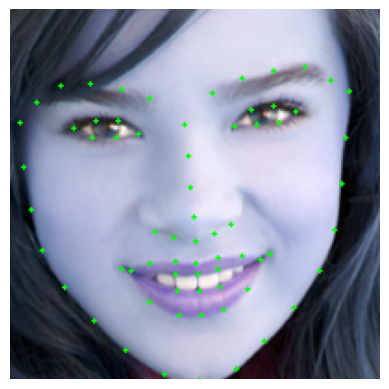

In [ ]:
#display_face_with_landmarks(img1[1][0],landmarks1[1][0])

In [ ]:
# Połącz listy, łacząc wszystkie grupy wiekowe
def concatenate_lists_age_class(*lists):
    output_lists = []

    for _ in range(age_classes):
        new_list = []  # Tworzymy nową pustą listę
        output_lists.append(new_list)

    for list_ in lists:
        i = 0
        for l in list_:
            output_lists[i].extend(l)
            i = i + 1
    return output_lists

images_man = concatenate_lists_age_class(img1_man,img2_man)
ages_man = concatenate_lists_age_class(ages1_man,ages2_man)
images_woman = concatenate_lists_age_class(img1_woman,img2_woman)
ages_woman = concatenate_lists_age_class(ages1_woman,ages2_woman)

#images = concatenate_lists_age_class(img1)
#ages = concatenate_lists_age_class(ages1)

#images = concatenate_lists_age_class(img1, img2)
#ages = concatenate_lists_age_class(ages1, ages2)
#gender = concatenate_lists_age_class(gender1, gender2)

#images = concatenate_lists_age_class(img1,img2,img3)
#landmarks = concatenate_lists_age_class(landmarks1,landmarks2,landmarks3)
#ages = concatenate_lists_age_class(ages1,ages2,ages3)

##Tutaj znajduje się kod zapisania, przerobionych/wyciętych twarzy z oryginalnego data_setu. Zdjęcia zippowane zapisujemy na swoim dysku Google

In [ ]:
# zapisywanei wyciętych zdjęć

from PIL import Image


def save_images(images, ages, landmarks, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, (image, age, landmark) in enumerate(zip(images, ages, landmarks)):
        # Konwertuj numpy array na obiekt Image z biblioteki PIL
        image_pil = Image.fromarray(image)

        # Twórz nazwę pliku na podstawie wieku i numeru elementu
        file_name = f"{age}_{i}.png"

        # Zapisz obraz do folderu wyjściowego
        file_path = os.path.join(output_folder, file_name)
        image_pil.save(file_path)

        file_name = f"{age}_{i}.npy"

        image_pil = Image.fromarray(image)

        file_path = os.path.join(output_folder, file_name)
        np.save(file_path, landmark)

# Bierze listę zdjęć/wieków podzieloną na klasy wiekowe i łaczy w jedną listę.
def merge_lists(lists):
    output_lists = []
    i = 0
    for _ in range(age_classes):
        output_lists.extend(lists[i])
        i = i + 1

    return output_lists




In [ ]:
images = merge_lists(images)
ages = merge_lists(ages)
landmarks = merge_lists(landmarks)

output_path= '/content/Croplandmarks_faces'

save_images(images, ages, landmarks, output_path)

In [ ]:
def odczytaj_dane_z_dysku(sciezka):
    lista_zdjec = []
    lista_wiekow = []
    lista_landmarkow = []

    for plik in os.listdir(sciezka):
       if plik.endswith(".png"):
            # Odczytaj wiek z nazwy pliku
            wiek_osoby = int(plik.split("_")[0])

            # Odczytaj obraz
            sciezka_zdjecia = os.path.join(sciezka, plik)
            zdjecie = cv2.imread(sciezka_zdjecia)

            # Odczytaj tablicę liczb
            numer_zdjecia = plik.split("_")[1].split('.')[0]
            sciezka_tablicy = os.path.join(sciezka, f"{wiek_osoby}_{numer_zdjecia}.npy")
            tablica = np.load(sciezka_tablicy)

            lista_zdjec.append(zdjecie)
            lista_wiekow.append(wiek_osoby)
            lista_landmarkow.append(tablica)

    return lista_zdjec, lista_wiekow, lista_landmarkow

In [ ]:
#images,ages,landmarks = odczytaj_dane_z_dysku('/content/Crop&landmarks_faces')

In [ ]:
import zipfile
import os

def zip_and_upload_to_google_drive(folder_path, zip_file_name):
    # Krok 1: Skompresuj folder do pliku zip
    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)



In [ ]:
## Zipuj przerobione zdjęcia

folder_path ='/content/Croplandmarks_faces'
zip_file_name = 'UTK_croplandmarks_faces.zip'

zip_and_upload_to_google_drive(folder_path,zip_file_name)

In [ ]:
# Wklej zipowane zdjęcia na dysk
!cp  /content/UTK_croplandmarks_faces.zip /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_croplandmarks_faces.zip

## 2. Augmentacja danych

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def augment_image(image, N=5):

    # Wczytaj obraz za pomocą Keras
    image_array = image
    image_array = np.expand_dims(image_array, axis=0)

    # Konfiguracja generatora augmentacji
    generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Wygeneruj N zaaugmentowanych obrazów
    augmented_images = []
    augmented_images.append(np.array(image).astype(float))
    for _ in range(N):
        augmented_image = generator.flow(image_array).next()[0]
        augmented_images.append(augmented_image)

    return augmented_images

In [ ]:
def augment_list(images, ages, N=5):
    images_output = []
    ages_output = []

    for i, (image, age) in enumerate(zip(images, ages)):

        augmented_images = augment_image(image, N)

        augmented_ages = [age] * (N + 1)

        images_output.extend(augmented_images)
        ages_output.extend(augmented_ages)

    return (images_output, ages_output)

In [ ]:
# wektor ile zdjęć augmentować dla danej grupy wiekowe
# Na przykład: jeżeli i-ty element wektora równa się 5 to funkcja stworzy 5 przekształconych zdjęć + 1 zdjęcie oryginalne

def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6


augment_amount_for_class = [3, 3, 5, 7, 8, 10]
augment_amount_for_class = [1, 1, 1, 1, 1, 3]

for i, N in enumerate(augment_amount_for_class):
    print(i)
    #images[i], ages[i] = augment_list(images[i], ages[i], N)

0
1
2
3
4
5



## 3. Zbiory treningowe

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# Łączenie wiele list w jedną listę.
def concatenate_lists(*lists):
    output_lists = []

    for list_ in lists:
        output_lists.extend(list_)

    return output_lists

# Bierze listę zdjęć/wieków podzieloną na klasy wiekowe i łaczy w jedną listę.
def merge_lists(lists):
    output_lists = []
    i = 0
    for _ in range(age_classes):
        output_lists.extend(lists[i])
        i = i + 1

    return output_lists

384

In [ ]:
## Przygotowanie zbiorów testowych/treningowych.
seed = 42

images = merge_lists(images)
ages = merge_lists(ages)
gender = merge_lists(gender)

#images = np.array(images)
##ages = np.array(ages)

# Podziel dane na dane treningowe (80%) i dane testowe (20%)
train_images, test_images, train_gender, test_gender = train_test_split(images, gender, test_size=0.2, random_state=seed)

NameError: name 'images' is not defined

In [ ]:
images = None
ages = None
gender = None

In [ ]:
## Przygotowanie zbiorów testowych/treningowych.
seed = 42

images_man = merge_lists(images_man)
ages_man = merge_lists(ages_man)

images_man = np.array(images_man)
ages_man = np.array(ages_man)

images_woman = merge_lists(images_woman)
ages_woman = merge_lists(ages_woman)

images_woman = np.array(images_woman)
ages_woman = np.array(ages_woman)


In [ ]:
classes, counts = np.unique(ages_man, return_counts=True)
print("Klasy:", classes)
print("Liczności klas:", counts)

Klasy: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  99 110]
Liczności klas: [1282  454  191  213  149   53  110  124  268  100   52   79   73  135
  146  251  120  115   59  119  164  175  153  305  321 1048  346  528
  338  383  205  379   76  288  599  346  228  197  212  396  115  220
  134   83  373  133  173  140  122  344  132  251  211  340  242  196
   95  304   98  205  154  131  109   49  226   49   90  105   30  123
   29   78   49   31  168   47   21   76   23  112   12   48   11    3
   68   22    6   13   17   82    1    6    1    2]


In [ ]:
# Podziel dane na dane treningowe (80%) i dane testowe (20%)
train_images_man, test_images_man, train_ages_man, test_ages_man = train_test_split(images_man, ages_man, test_size=0.2, random_state=seed)

images_man = None
ages_man = None


In [ ]:
# Podziel dane na dane treningowe (80%) i dane testowe (20%)
train_images_woman, test_images_woman, train_ages_woman, test_ages_woman = train_test_split(images_woman, ages_woman, test_size=0.2, random_state=seed)

images_woman = None
ages_woman = None

In [ ]:
# Wyświetl rozmiary danych treningowych i walidacyjnych dla mężczyzn
print(f"Liczba obrazów treningowych: {len(train_images_man)}")
print(f"Liczba wieków treningowych: {len(train_ages_man)}")
print(f"Liczba obrazów walidacyjnych: {len(test_images_man)}")
print(f"Liczba wieków walidacyjnych: {len(test_ages_man)}")

# Wyświetl rozmiary danych treningowych i walidacyjnych dla kobiet
print(f"Liczba obrazów treningowych: {len(train_images_woman)}")
print(f"Liczba wieków treningowych: {len(train_ages_woman)}")
print(f"Liczba obrazów walidacyjnych: {len(test_images_woman)}")
print(f"Liczba wieków walidacyjnych: {len(test_ages_woman)}")

Liczba obrazów treningowych: 13346
Liczba wieków treningowych: 13346
Liczba obrazów walidacyjnych: 3337
Liczba wieków walidacyjnych: 3337
Liczba obrazów treningowych: 13366
Liczba wieków treningowych: 13366
Liczba obrazów walidacyjnych: 3342
Liczba wieków walidacyjnych: 3342


In [ ]:
# Funkcja do przetwarzania obrazów
# Tutaj możemy na przykład przerobić obraz na czarno-biały.

def preprocess_image(image, age):
    #image = image / 255.0  # Normalizacja wartości pikseli do zakresu [0, 1]

    return image, age

In [ ]:
batch_size_param = 512

# Utwórz dataset dla danych treningowych
#train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_ages))
##train_dataset = train_dataset.map(preprocess_image)
###train_dataset = train_dataset.batch(batch_size_param)

# Utwórz dataset dla danych testowych
#test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_ages))
#test_dataset = test_dataset.map(preprocess_image)
#test_dataset = test_dataset.batch(batch_size_param)

# 4. Tworzenie modelu

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, MaxPool2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
def big_age_model():
  age_model = Sequential()
  age_model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(img_width,img_height,3)))
  #age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
  age_model.add(MaxPool2D(pool_size=3, strides=2))

  age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
  #age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
  age_model.add(MaxPool2D(pool_size=3, strides=2))

  age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
  #age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
  age_model.add(MaxPool2D(pool_size=3, strides=2))

  age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
  #age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
  age_model.add(MaxPool2D(pool_size=3, strides=2))

  age_model.add(Flatten())
  age_model.add(Dropout(0.2))
  age_model.add(Dense(512, activation='relu'))

  age_model.add(Dense(1, activation='linear', name='age'))

  age_model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])

  return age_model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def identity_block(x, filters):
    # Blok tożsamości ResNet
    f1, f2, f3 = filters

    x_shortcut = x

    x = layers.Conv2D(f1, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f2, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f3, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_shortcut])
    x = layers.Activation('relu')(x)

    return x

def convolutional_block(x, filters, s):
    # Blok konwolucyjny ResNet
    f1, f2, f3 = filters

    x_shortcut = x

    x = layers.Conv2D(f1, (1, 1), strides=(s, s), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f2, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f3, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)

    x_shortcut = layers.Conv2D(f3, (1, 1), strides=(s, s), padding='valid')(x_shortcut)
    x_shortcut = layers.BatchNormalization()(x_shortcut)

    x = layers.add([x, x_shortcut])
    x = layers.Activation('relu')(x)

    return x

def ResNet50_Gender(input_shape=(64, 64, 3), num_classes=1):
    # Model ResNet50-like
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = convolutional_block(x, filters=[64, 64, 256], s=1)
    x = identity_block(x, filters=[64, 64, 256])
    x = identity_block(x, filters=[64, 64, 256])

    x = convolutional_block(x, filters=[128, 128, 512], s=2)
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])

    x = convolutional_block(x, filters=[256, 256, 1024], s=2)
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])

    x = convolutional_block(x, filters=[512, 512, 2048], s=2)
    x = identity_block(x, filters=[512, 512, 2048])
    x = identity_block(x, filters=[512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='ResNet50_gender')
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense, Dropout

def identity_block(x, filters):
    x_shortcut = x
    x = Conv2D(filters[0], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters[1], (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters[2], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def convolutional_block(x, filters, strides):
    x_shortcut = Conv2D(filters[2], (1, 1), strides=strides, padding='valid')(x)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Conv2D(filters[0], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters[1], (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters[2], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def CnnRegression(input_shape=(100, 100, 3)):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = AveragePooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = convolutional_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = convolutional_block(x, [128, 128, 512], strides=(2, 2))
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = convolutional_block(x, [256, 256, 1024], strides=(2, 2))
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = convolutional_block(x, [512, 512, 2048], strides=(2, 2))
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = AveragePooling2D((4, 4))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='CnnRegression')
    return model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def identity_block(x, filters):
    f1, f2, f3 = filters

    x_shortcut = x

    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def convolutional_block(x, filters, s=2):
    f1, f2, f3 = filters

    x_shortcut = x

    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x_shortcut = Conv2D(f3, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def ResNet50(input_shape=(100, 100, 3), num_classes=1):
    x_input = Input(input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = convolutional_block(x, filters=[64, 64, 256], s=1)
    x = identity_block(x, filters=[64, 64, 256])
    x = identity_block(x, filters=[64, 64, 256])

    x = convolutional_block(x, filters=[128, 128, 512], s=2)
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])

    x = convolutional_block(x, filters=[256, 256, 1024], s=2)
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])

    x = convolutional_block(x, filters=[512, 512, 2048], s=2)
    x = identity_block(x, filters=[512, 512, 2048])
    x = identity_block(x, filters=[512, 512, 2048])

    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='linear')(x)

    model = Model(inputs=x_input, outputs=x, name='ResNet50')

    return model

In [ ]:
img_width = 64
img_height = 64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_path = "/content/checkpoint/model_man.ckpt"
checkpoint_callback_man = ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', save_weights_only=False, save_best_only=True)

checkpoint_path = "/content/checkpoint/model_woman.ckpt"
checkpoint_callback_woman = ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', save_weights_only=False, save_best_only=True)

In [ ]:

model_man = ResNet50(input_shape=(img_width, img_height, 3), num_classes=1)
model_woman = ResNet50(input_shape=(img_width, img_height, 3), num_classes=1)

model_man.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae','mse','accuracy'])
model_woman.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae','mse','accuracy'])



In [ ]:
from tensorflow.keras.models import load_model

model_man

In [ ]:
model_gender = ResNet50_Gender(input_shape=(img_width,img_height,3))


In [ ]:
model_gender.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
checkpoint_path = "/content/checkpoint/model_gender.ckpt"
checkpoint_callback_man = ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', save_weights_only=False, save_best_only=True)


In [ ]:
train_gender = np.reshape(train_gender,(-1,1))
test_gender = np.reshape(test_gender,(-1,1))

In [ ]:
train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
print(len(train_gender))
print(len(test_gender))
print(len(train_images))
print(len(test_images))

26712
6679
26712
6679


In [ ]:
model_history_gender = model_gender.fit(train_images, train_gender, epochs=10, batch_size=16, shuffle=True, validation_data=(test_images, test_gender), callbacks=[checkpoint_callback_man])


Epoch 1/30
1670/1670 [==============================] - 152s 68ms/step - loss: 0.4938 - accuracy: 0.7811 - val_loss: 0.3870 - val_accuracy: 0.8256
Epoch 2/30
1670/1670 [==============================] - 111s 66ms/step - loss: 0.3771 - accuracy: 0.8316 - val_loss: 0.5083 - val_accuracy: 0.7589
Epoch 3/30
1670/1670 [==============================] - 85s 51ms/step - loss: 0.4191 - accuracy: 0.8051 - val_loss: 0.3936 - val_accuracy: 0.8280
Epoch 4/30
1670/1670 [==============================] - 107s 64ms/step - loss: 0.3107 - accuracy: 0.8604 - val_loss: 0.3452 - val_accuracy: 0.8416
Epoch 5/30
1670/1670 [==============================] - 84s 51ms/step - loss: 0.3204 - accuracy: 0.8568 - val_loss: 0.3172 - val_accuracy: 0.8464
Epoch 6/30
1670/1670 [==============================] - 109s 66ms/step - loss: 0.2714 - accuracy: 0.8784 - val_loss: 0.3176 - val_accuracy: 0.8578
Epoch 7/30
1670/1670 [==============================] - 108s 65ms/step - loss: 0.2512 - accuracy: 0.8893 - val_loss: 0.2

In [ ]:
# Trenowanie modelu dla mężczyzn
model_history_man = model_man.fit(train_images_man, train_ages_man, epochs=10, batch_size=8, shuffle=True, validation_data=(test_images_man, test_ages_man), callbacks=[checkpoint_callback_man])


In [ ]:
# Trenowanie modelu dla kobiet
model_history_woman = model_woman.fit(train_images_woman, train_ages_woman, epochs=30, batch_size=16, shuffle=cv2.fastNlMeansDenoisingColored, validation_data=(test_images_woman, test_ages_woman), callbacks=[checkpoint_callback_woman])


Epoch 1/30
209/209 [==============================] - 97s 313ms/step - loss: 12.3557 - mae: 12.3557 - mse: 311.8685 - accuracy: 0.0507 - val_loss: 20.8719 - val_mae: 20.8719 - val_mse: 694.8600 - val_accuracy: 0.0066
Epoch 2/30
209/209 [==============================] - 68s 325ms/step - loss: 9.2804 - mae: 9.2804 - mse: 188.2623 - accuracy: 0.0483 - val_loss: 12.5035 - val_mae: 12.5035 - val_mse: 310.0645 - val_accuracy: 0.0563
Epoch 3/30
209/209 [==============================] - 74s 356ms/step - loss: 8.1777 - mae: 8.1777 - mse: 150.4302 - accuracy: 0.0498 - val_loss: 12.2236 - val_mae: 12.2236 - val_mse: 270.9751 - val_accuracy: 0.0569
Epoch 4/30
209/209 [==============================] - 77s 368ms/step - loss: 7.5022 - mae: 7.5022 - mse: 125.7274 - accuracy: 0.0496 - val_loss: 9.1938 - val_mae: 9.1938 - val_mse: 181.2156 - val_accuracy: 0.0227
Epoch 5/30
209/209 [==============================] - 18s 88ms/step - loss: 6.8365 - mae: 6.8365 - mse: 106.5280 - accuracy: 0.0486 - val_lo

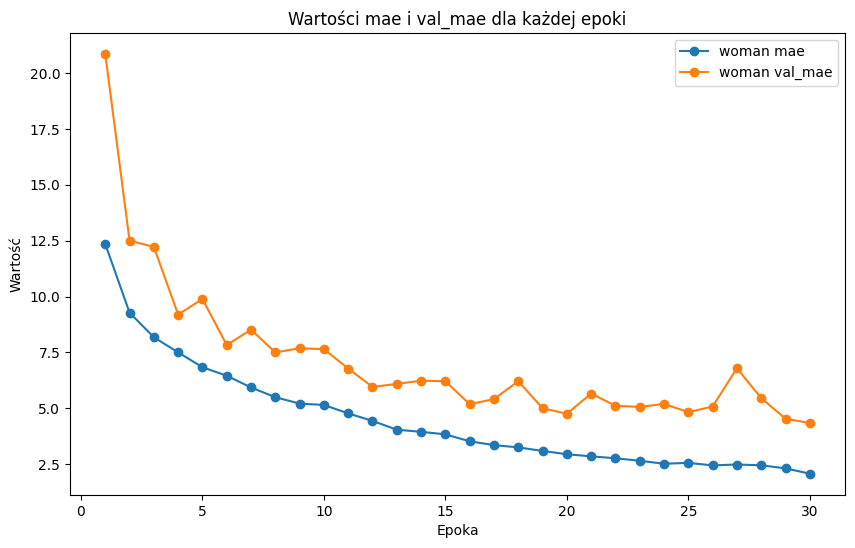

In [ ]:
import matplotlib.pyplot as plt


# Numeracja epok
epochs = list(range(1, 31))

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(epochs, woman_mae, label='woman mae', marker='o')
plt.plot(epochs, woman_val_mae, label='woman val_mae', marker='o')

# Dodanie tytułów i etykiet osi
plt.title('Wartości mae i val_mae dla każdej epoki')
plt.xlabel('Epoka')
plt.ylabel('Wartość')
plt.legend()  # Dodanie legendy

# Wyświetlenie wykresu
plt.show()

In [ ]:
train_images_man = None
train_images_woman = None

# 4.2 Wczytywanie modelu  i łaczenie modeli

In [ ]:
!cp /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/Genmodel1.h5 /content/models/Genmodel1.h5
!cp /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_faces_man.h5 /content/models/UTK_faces_man.h5
!cp /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_faces_woman.h5 /content/models/UTK_faces_woman.h5

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Lambda, UpSampling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import load_model, clone_model


In [ ]:


model_deepface = load_model('/content/models/Genmodel1.h5')
model_utk_man = load_model('/content/models/UTK_faces_man.h5')
model_utk_woman = load_model('/content/models/UTK_faces_woman.h5')

In [ ]:

# Stwórz nowy model z tą samą architekturą, ale bez wag
model_utk_woman = clone_model(model_utk_woman)

# Przypisz nową nazwę do nowego modelu
model_utk_woman ._name = 'ResNet50Woman'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
combined_model = None

input_shape = (64, 64, 3)  # Rozmiar wejścia dla modeli utk
combined_input = Input(shape=input_shape, name='combined_input')

# Dopasuj rozmiar wejścia modelu_deepface do 64x64
resized_input = Lambda(lambda x: tf.image.resize(x, (64, 64)))(combined_input)

# Stwórz warstwę dla predykcji płci
gender_prediction = model_deepface(resized_input)

# Wybierz odpowiedni model w zależności od płci
output = tf.cond(tf.math.greater(gender_prediction, 0.5),
                 lambda: model_utk_woman(combined_input),
                 lambda: model_utk_man(combined_input))

# Stwórz model
combined_model = Model(inputs=combined_input, outputs=output)

# Wyświetl informacje o modelu
combined_model.summary()

ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).

Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 67712, but received input with shape (None, 4608)

Call arguments received by layer "sequential_1" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
  • training=None
  • mask=None

In [ ]:
from tensorflow.keras.utils import plot_model

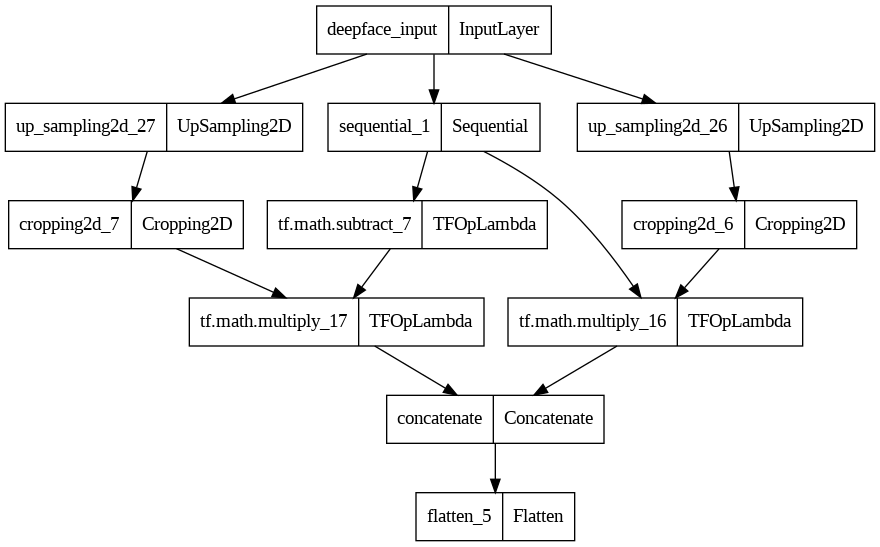

In [ ]:
plot_model(combined_model)

In [ ]:
from PIL import Image

nowy_rozmiar = (200, 200)
lista_obrazow = test_images_man[1:100]

def przetworz_i_znormalizuj(obraz, nowy_rozmiar):
    obraz_resized = np.array(Image.fromarray(obraz.astype(np.uint8)).resize(nowy_rozmiar))
    obraz_znormalizowany = obraz_resized.astype('float32')
    return obraz_znormalizowany

# Przetwarzanie i normalizacja każdego obrazu w liście
test_list = [przetworz_i_znormalizuj(obraz, nowy_rozmiar) for obraz in lista_obrazow]


In [ ]:
input_data = np.array(test_list).reshape((-1, 200, 200, 3))

In [ ]:
input_data.shape

(99, 200, 200, 3)

In [ ]:
combined_model.predict(input_data)

InvalidArgumentError: Graph execution error:

Detected at node model_14/tf.math.multiply_16/Mul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-142-8d2985f3a7fe>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/tf_op_layer.py", line 242, in _call_wrapper

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/tf_op_layer.py", line 279, in _call_wrapper

required broadcastable shapes
	 [[{{node model_14/tf.math.multiply_16/Mul}}]] [Op:__inference_predict_function_56253]

# 5. Testowanie Modelu

In [ ]:
def Model_History(model, model_history):
  #Historia trenowania
  print(model.metrics_names)
  train_loss = model_history.history['loss']
  test_loss = model_history.history['val_loss']
  #train_accuracy = model_history.history['accuracy']
  #test_accuracy = model_history.history['val_accuracy']

  # Plotting a line chart to visualize the loss and accuracy values by epochs.
  fig, ax = plt.subplots(ncols=2, figsize=(15,7))
  ax = ax.ravel()
  ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
  ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
  ax[0].set_xlabel('Epochs', fontsize=14)
  ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
  ax[0].legend(fontsize=14)
  ax[0].tick_params(axis='both', labelsize=12)
  #ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
  #ax[1].plot(test_accuracy, label='Test Accuracy', color= 'orangered', marker='o', markersize=5)
  #ax[1].set_xlabel('Epochs', fontsize=14)
  #ax[1].set_ylabel('Accuracy', fontsize=14)
  #ax[1].legend(fontsize=14)
  #ax[1].tick_params(axis='both', labelsize=12)
  fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [ ]:
Model_History(model_man, model_history_man)

In [ ]:
Model_History(model_woman, model_history_woman)

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

def Check_MAE(model,test_ages,test_images):
  imgs = list(range(0, len(test_ages)-1))

  mae = mean_absolute_error(test_ages[imgs], model.predict(test_images[imgs]))
  mse = mean_squared_error(test_ages[imgs], model.predict(test_images[imgs]))

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')

In [ ]:
Check_MAE(model_man,test_ages_man,test_images_man)
Check_MAE(model_woman,test_ages_woman,test_images_woman)

105/105 [==============================] - 1s 12ms/step
MAE: 3.411360709385263
MSE: 31.224657453643275
105/105 [==============================] - 1s 13ms/step
MAE: 2.625916027926428
MSE: 20.247629053703626


In [ ]:
final_score = model.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_labels = model.metrics_names
print(f'CNN model {final_labels[0]} \t\t= {round(final_score[0], 3)}')
print(f'CNN model {final_labels[1]} \t= {round(final_score[1], 3)}')


In [ ]:
def Save_Model(model, saved_model_path):
  # Saving the model as a h5 file for possible use later.
  model.save(saved_model_path, save_format='h5')

saved_model_path_man = '/content/models_saved/UTK_faces_man.h5'
saved_model_path_woman = '/content/models_saved/UTK_faces_woman.h5'
saved_model_path_gender = '/content/models_saved/UTK_faces_gender.h5'


In [ ]:
Save_Model(model_man, saved_model_path_man)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Save_Model(model_gender, saved_model_path_gender)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#!cp /content/models_saved/UTK_faces_woman.h5 /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_faces_woman.h5

In [ ]:
!cp /content/models_saved/UTK_faces_gender.h5 /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_faces_gender.h5

In [ ]:
!cp /content/models_saved/UTK_faces_man.h5 /content/drive/MyDrive/Studia/Projekty/MachineLearning/dataset/UTK_face/UTK_faces_man2.h5

# Testowanie przećwiczonych i załadowanych modeli


In [ ]:
#!pip install deepface


In [ ]:
from deepface import DeepFace

def Predict_age(image, model_man, model_woman):
  #image = cv2.resize(image , (img_width, img_height))
  gender_result = DeepFace.analyze(image, actions=['gender'], enforce_detection=False)
  list_ = []
  list_.append(image)
  list_ = np.array(list_)
  plt.imshow(image)
  #print("Gender result:", gender_result)
  if(gender_result[0]['gender']['Woman']>0.5):
    #Kobieta
    return model_woman.predict(list_)[0]
  else:
    #Mężczyzna
    return model_man.predict(list_)[0]

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

def predict_ages(images, ages, model_man, model_woman):
    wyniki = []
    i = 0
    for image in images:
      print(Predict_age(image,model_man,model_woman),' prawdziwy: ',ages[i])
      wyniki.append(Predict_age(image,model_man,model_woman))
      i = i + 1

    mae = mean_absolute_error(wyniki,ages)
    mse = mean_squared_error(ages, wyniki)

    print(f'MAE: {mae}')
    print(f'MSE: {mse}')


1/1 [==============================] - 0s 55ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

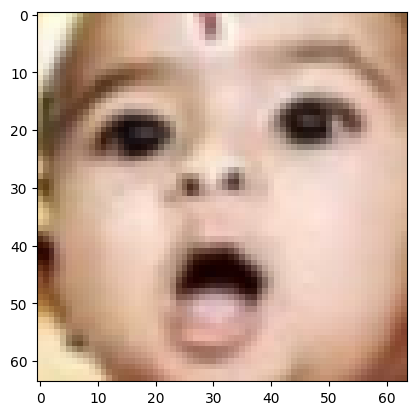

In [ ]:
predict_ages(test_images[1:10], test_ages[1:10], model_man, model_woman)

In [ ]:
Check_MAE(model_man, test_ages[1:100], test_images[1:100])

TypeError: list indices must be integers or slices, not list

In [ ]:
Check_MAE(model,test_ages,test_images):

SyntaxError: invalid syntax (<ipython-input-23-afb788c02ea5>, line 1)

In [ ]:
import tensorflow as tf

# Wczytywanie modelu z pliku .h5
model_man_path = '/content/models_saved/UTK_faces_man.h5'
model_woman_path = '/content/models_saved/UTK_faces_woman.h5'
model_man = tf.keras.models.load_model(model_man_path)
model_woman = tf.keras.models.load_model(model_woman_path)

In [ ]:
Check_MAE(model_man,test_ages_man,test_images_man)
Check_MAE(model_woman,test_ages_woman,test_images_woman)

105/105 [==============================] - 1s 14ms/step
MAE: 3.452347548146971
MSE: 31.117147699167568


In [ ]:
# Generating predictions from the model above.
final_pred = model.predict(test_dataset)
final_pred = final_pred.argmax(axis=-1)

# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_ages, final_pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    #plt.savefig(f'/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');



In [ ]:
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))

plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()